In [1]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

# importing torch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

# setting dtype and seeds for repoducibility
dtype = torch.float32
torch.set_default_dtype(dtype)
torch.manual_seed(40)
np.random.seed(40)

In [2]:
# constants
reduced_h = 1.0
mass = 1.0

# dirichlet boundary conditions
x_l = 0.0
x_r = +1.0
l = x_r - x_l
f_b = 0.0

# potential function
def potential(x):
    return torch.where((x <= x_r) & (x >= x_l), torch.tensor(0.0), torch.tensor(float('inf')))

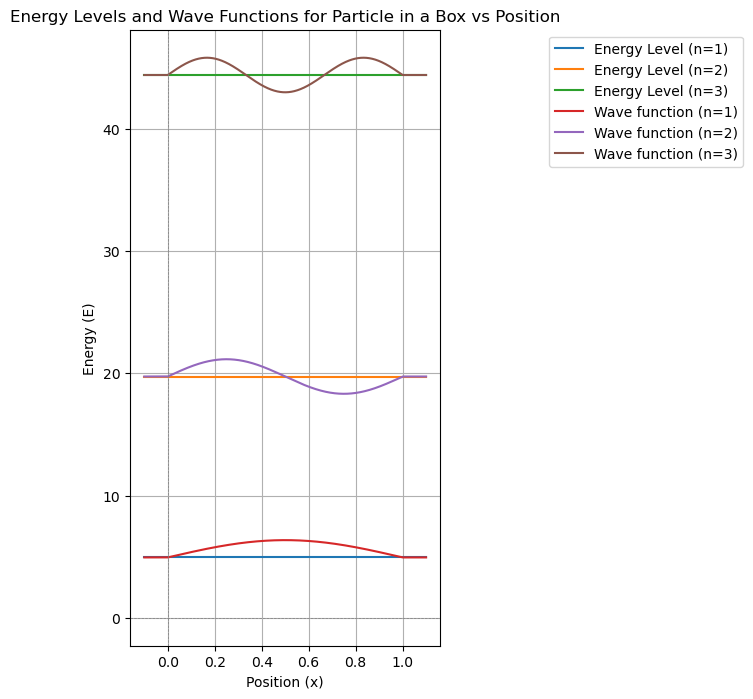

In [3]:
# exact solution
def wavefn(n, x):
    condition = (x >= x_l) & (x <= x_r)
    result = torch.zeros_like(x)
    result[condition] = torch.sqrt(2/torch.tensor(l)) * torch.sin(n * np.pi * x[condition] / torch.tensor(l))
    return result

def energy(n):
    return (n**2 * np.pi**2 * reduced_h**2) / (2 * mass * l**2)

# plotting the exact solutions
x_values = torch.linspace(x_l - 0.1, x_r + 0.1, 1000)
num_max = 3 

energy_levels = np.array([[energy(n) for _ in x_values] for n in range(1, num_max+1)])
wave_functions = np.array([[wavefn(n, x).detach().numpy() for x in x_values] for n in range(1, num_max+1)])

plt.figure(figsize=(4, 8))

for n in range(num_max):
    plt.plot(x_values, energy_levels[n], label=f'Energy Level (n={n+1})')

for n in range(num_max):
    plt.plot(x_values, energy_levels[n] + wave_functions[n], label=f'Wave function (n={n+1})')

plt.xlabel('Position (x)')
plt.ylabel('Energy (E)')
plt.title('Energy Levels and Wave Functions for Particle in a Box vs Position')
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Horizontal line at y=0
plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')  # Vertical line at x=0

plt.legend(loc='upper right', bbox_to_anchor=(2, 1))
plt.grid(True)
plt.show()

In [4]:
# custom activation function
class sinfn(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)
    
# autograd differentiation function
def dfx(x,f):
    return grad(f, x, grad_outputs=torch.ones(x.shape), create_graph=True)[0]

# parameterized solution
def solution(x, model):
    phi, _ = model(x)
    g = (1-torch.exp(c*(x_l - x)))*(1-torch.exp(c*(x - x_r)))
    psi = f_b + g * phi
    return psi

# gaussian perturbation to inputs
def perturb(sample, x_l, x_r, sigma=0.5):
    sample_range = sample.max() - sample.min()
    scale_factor = (x_r - x_l) / sample_range
    scaled_sample = (sample - sample.min()) * scale_factor + x_l
    noise = torch.randn_like(sample) * sigma
    x = scaled_sample + noise
    x.clamp_(x_l, x_r)
    x[0] = x_l
    x[-1] = x_r
    x.requires_grad = False  
    return x


In [5]:
# neural network model
class EigenNN(nn.Module):
    def __init__(self, num_neurons=50):
        super(EigenNN, self).__init__()
        self.activation = sinfn()
        self.eigen  = nn.Linear(1,1)
        self.linear1  = nn.Linear(2, num_neurons)
        self.linear2  = nn.Linear(num_neurons, num_neurons)
        self.out    = nn.Linear(num_neurons, 1)

    def forward(self, x):
        value = self.eigen(torch.ones_like(x))
        psi = self.linear1(torch.cat((x, value),1))
        psi = self.activation(psi)
        psi = self.linear2(psi)
        psi = self.activation(psi)
        psi = self.out(psi)
        return psi, value

In [6]:
# model specifications
num_neurons = 50
model = EigenNN(num_neurons)
best_model = 0 

# optimizer specifications
lr = 8e-3
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

# regularization constants
vf = 1
vl = 1
vd = 1

# hyperparameter
c = 1
limits = 1e+20
walle = -4

# loss histories
loss_history = []
Lde_history = []
Ld_history = []
Lf_history = []
Ll_history = []

# eigenvalue history
En_history = []
wall_history = []

E_limits = (None, 1e+20)
models = {0:E_limits, 1:E_limits, 2:E_limits, 3:E_limits, 4:E_limits, 5:E_limits, 6:E_limits, 7:E_limits, 8:E_limits, 9:E_limits, 10:E_limits}

# inputs
num_train = 100
sample = torch.linspace(x_l, x_r, num_train).reshape(-1,1)

num_epochs = int(150e+3)

for epoch in tqdm(range(num_epochs)): 
    data_train = perturb(sample, x_l, x_r, sigma = .03*x_r)
    data_train = data_train[np.random.permutation(num_train)]
    data_train.requires_grad = True
        
    _, En = model(data_train)
    En_history.append(En[0].data.tolist()[0])

    psi  = solution(data_train, model)
    V0 = potential(data_train)

    psix = dfx(data_train, psi)
    psixx = dfx(data_train, psix)
    Lde = ((reduced_h**2/(2*mass)) * psixx + (En-V0)*psi).pow(2).mean()
    Lde_history.append(Lde.detach().numpy())
            
    if epoch%1000 == 0:
        walle += 0.5

    Lf = 1/((psi.pow(2)).mean()+1e-6)
    Ll = 1/(En.pow(2).mean()+1e-6)
    Ld = torch.exp(-1*En + walle).mean()
            
    loss = Lde + vf*Lf + vl*Ll + vd*Ld

    Ld_history.append(Ld.detach().numpy())
    Ll_history.append(Ll.detach().numpy())
    Lf_history.append(Lf.detach().numpy())
    wall_history.append(walle)

    loss.backward(retain_graph=False)
    optimizer.step()
    optimizer.zero_grad()
    loss_history.append(loss.data.numpy())

    if  Lde < limits:
        best_model =  copy.deepcopy(model)
        limits = Lde

    bin = abs(En[0].data.tolist()[0]//10) 
    if Lde < models[bin][1]:
          models[bin] = (copy.deepcopy(model), Lde)

loss_history = np.array(loss_history)
Lde_history = np.array(Lde_history)
Lf_history = np.array(Lf_history)
Ll_history = np.array(Ll_history)
Ld_history = np.array(Ld_history)

En_history = np.array(En_history)
wall_history = np.array(wall_history)

model = best_model

100%|██████████| 150000/150000 [10:39<00:00, 234.50it/s]


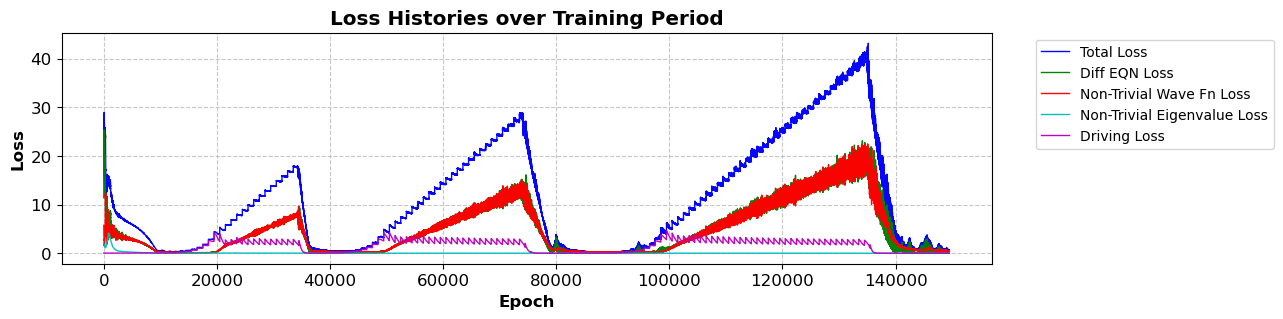

In [7]:
fig, ax = plt.subplots(figsize=(12, 3))
num = 500
ax.plot(loss_history[num:], '-b', linewidth=1, alpha=0.975, label='Total Loss') 
ax.plot(Lde_history[num:], '-g', linewidth=1, alpha=0.975, label='Diff EQN Loss') 
ax.plot(Lf_history[num:], '-r', linewidth=1, alpha=0.975, label='Non-Trivial Wave Fn Loss') 
ax.plot(Ll_history[num:], '-c', linewidth=1, alpha=0.975, label='Non-Trivial Eigenvalue Loss')
ax.plot(Ld_history[num:], '-m', linewidth=1, alpha=0.975, label='Driving Loss')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch', fontsize='large', fontweight='bold')
ax.set_ylabel('Loss', fontsize='large', fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize='large')
ax.set_title('Loss Histories over Training Period', fontsize='x-large', fontweight='bold')
plt.show()

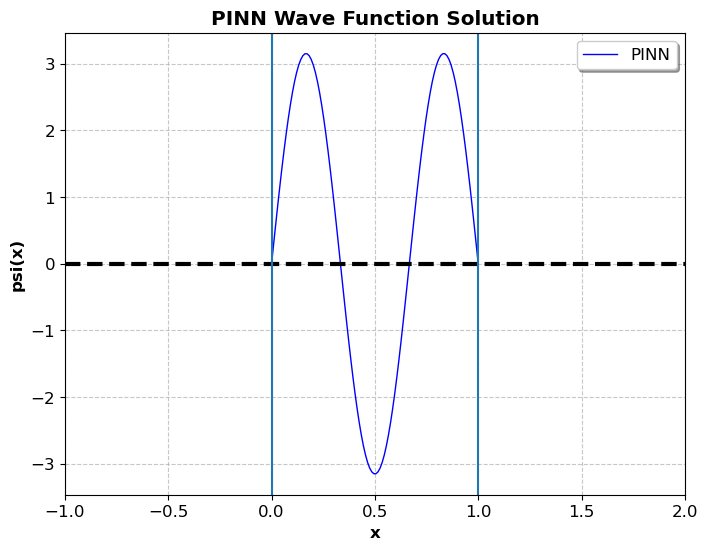

In [10]:
# extracting and plotting results from the trained PINN
num_test = num_train 
data_test = torch.linspace(x_l, x_r, num_test)
data_test = data_test.reshape(-1, 1)
data_test.requires_grad = True
data_net = data_test.detach().numpy()
psi = solution(data_test, model) 
psi = (-1)*psi.data.numpy()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(data_net, psi, '-b', linewidth=1, label='PINN') 
ax.legend() 
ax.axhline(y=0, color='k', linestyle='--', linewidth=3) 
ax.set_xlim(-1, 2) 
ax.axvline(x = 0)
ax.axvline(x = 1)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize='large', shadow=True)
ax.set_xlabel('x', fontsize='large', fontweight='bold')
ax.set_ylabel('psi(x)', fontsize='large', fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize='large')
ax.set_title('PINN Wave Function Solution', fontsize='x-large', fontweight='bold')
plt.show()


In [15]:
print("Predicted Energy of Infinite Pot Well for n=1 :", models[0][0].forward(data_test)[1][0].data.numpy(), "Exact Energy :", energy(1))
print("Predicted Energy of Infinite Pot Well for n=2 :", models[1][0].forward(data_test)[1][0].data.numpy(), "Exact Energy :", energy(2))
print("Predicted Energy of Infinite Pot Well for n=3 :", models[4][0].forward(data_test)[1][0].data.numpy(), "Exact Energy :", energy(3))
print("Predicted Energy of Infinite Pot Well for n=4 :", models[7][0].forward(data_test)[1][0].data.numpy(), "Exact Energy :", energy(4))

Predicted Energy of Infinite Pot Well for n=1 : [4.936437] Exact Energy : 4.934802200544679
Predicted Energy of Infinite Pot Well for n=2 : [19.73981] Exact Energy : 19.739208802178716
Predicted Energy of Infinite Pot Well for n=3 : [44.41262] Exact Energy : 44.41321980490211
Predicted Energy of Infinite Pot Well for n=4 : [78.94798] Exact Energy : 78.95683520871486


# Error Analysis

## Ground state

Mean Squared Error: [7.2210835e-11]


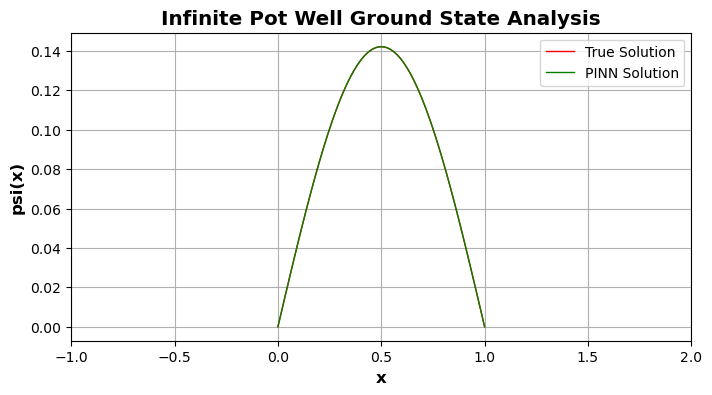

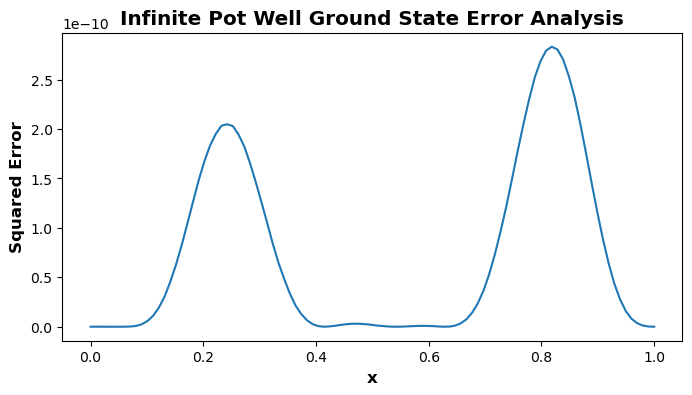

In [16]:
figsize = (8,4)
plt.figure(figsize = figsize)

psi = solution(data_test, models[0][0])
psi = psi.data.numpy() 
tru = wavefn(n=1, x=data_test).detach().numpy()

# normalization
psi = (-1)*psi/np.linalg.norm(psi)
tru = tru/np.linalg.norm(tru)

plt.plot(data_net, tru, '-r', linewidth=1, label = 'True Solution')
plt.plot(data_net, psi, '-g', linewidth=1, label = 'PINN Solution')
plt.xlim(-1,2)
plt.legend()
plt.xlabel('x', fontsize='large', fontweight='bold')
plt.ylabel('psi(x)', fontsize='large', fontweight='bold')
plt.grid('on')
plt.title('Infinite Pot Well Ground State Analysis', fontsize='x-large', fontweight='bold')

plt.figure(figsize = figsize)
plt.plot(data_net, (tru-psi)**2)
plt.title('Infinite Pot Well Ground State Error Analysis', fontsize='x-large', fontweight='bold')
plt.ylabel('Squared Error', fontsize='large', fontweight='bold')
plt.xlabel('x', fontsize='large', fontweight='bold')
print('Mean Squared Error: ' + str(sum((tru-psi)**2)/len(tru)))


## First Excited

Mean Squared Error: [6.065788e-09]


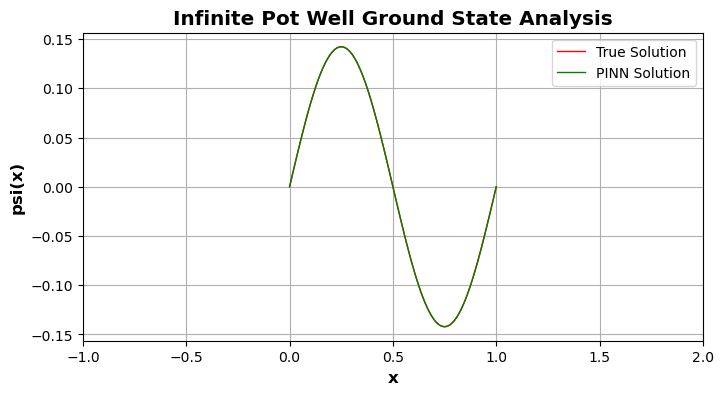

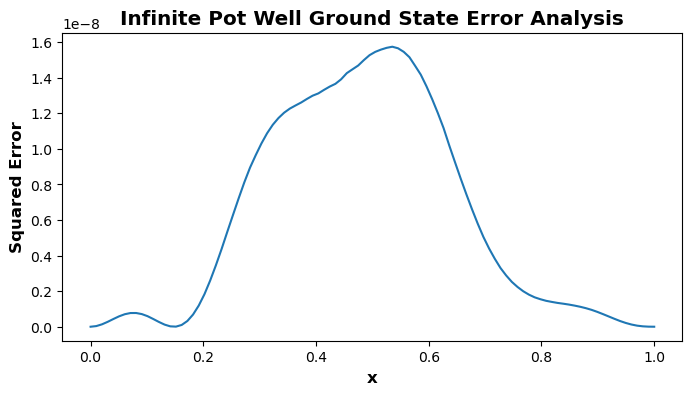

In [17]:
figsize = (8,4)
plt.figure(figsize = figsize)

psi = solution(data_test, models[1][0])
psi = psi.data.numpy() 
tru = wavefn(n=2, x=data_test).detach().numpy()

# normalization
psi = (-1)*psi/np.linalg.norm(psi)
tru = tru/np.linalg.norm(tru)

plt.plot(data_net, tru, '-r', linewidth=1, label = 'True Solution')
plt.plot(data_net, psi, '-g', linewidth=1, label = 'PINN Solution')
plt.xlim(-1,2)
plt.legend()
plt.xlabel('x', fontsize='large', fontweight='bold')
plt.ylabel('psi(x)', fontsize='large', fontweight='bold')
plt.grid('on')
plt.title('Infinite Pot Well Ground State Analysis', fontsize='x-large', fontweight='bold')

plt.figure(figsize = figsize)
plt.plot(data_net, (tru-psi)**2)
plt.title('Infinite Pot Well Ground State Error Analysis', fontsize='x-large', fontweight='bold')
plt.ylabel('Squared Error', fontsize='large', fontweight='bold')
plt.xlabel('x', fontsize='large', fontweight='bold')
print('Mean Squared Error: ' + str(sum((tru-psi)**2)/len(tru)))


## Second Excited

Mean Squared Error: [9.870174e-10]


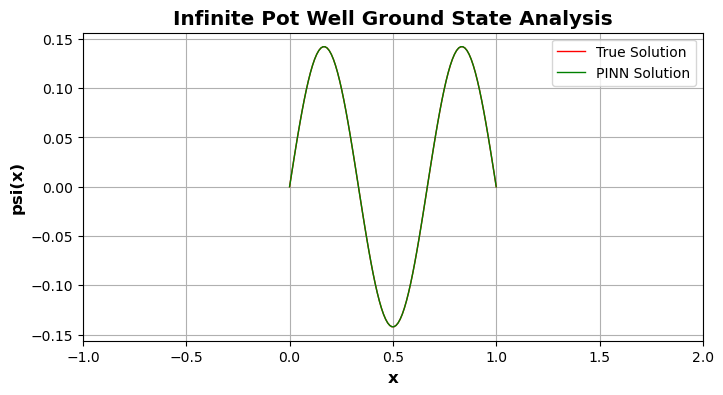

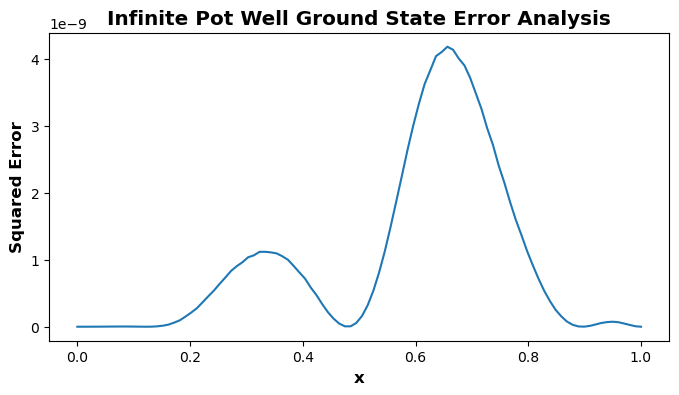

In [19]:
figsize = (8,4)
plt.figure(figsize = figsize)

psi = solution(data_test, models[4][0])
psi = psi.data.numpy() 
tru = wavefn(n=3, x=data_test).detach().numpy()

# normalization
psi = (-1)*psi/np.linalg.norm(psi)
tru = tru/np.linalg.norm(tru)

plt.plot(data_net, tru, '-r', linewidth=1, label = 'True Solution')
plt.plot(data_net, psi, '-g', linewidth=1, label = 'PINN Solution')
plt.xlim(-1,2)
plt.legend()
plt.xlabel('x', fontsize='large', fontweight='bold')
plt.ylabel('psi(x)', fontsize='large', fontweight='bold')
plt.grid('on')
plt.title('Infinite Pot Well Ground State Analysis', fontsize='x-large', fontweight='bold')

plt.figure(figsize = figsize)
plt.plot(data_net, (tru-psi)**2)
plt.title('Infinite Pot Well Ground State Error Analysis', fontsize='x-large', fontweight='bold')
plt.ylabel('Squared Error', fontsize='large', fontweight='bold')
plt.xlabel('x', fontsize='large', fontweight='bold')
print('Mean Squared Error: ' + str(sum((tru-psi)**2)/len(tru)))

## Third Excited

Mean Squared Error: [8.9099734e-07]


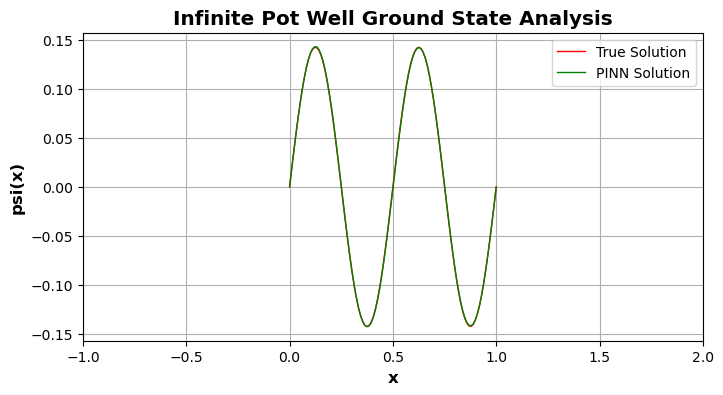

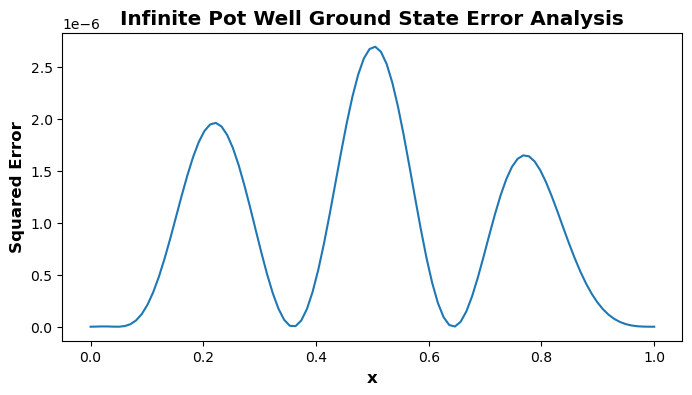

In [23]:
figsize = (8,4)
plt.figure(figsize = figsize)

psi = solution(data_test, models[7][0])
psi = psi.data.numpy() 
tru = wavefn(n=4, x=data_test).detach().numpy()

# normalization
psi = (-1)*psi/np.linalg.norm(psi)
tru = tru/np.linalg.norm(tru)

plt.plot(data_net, tru, '-r', linewidth=1, label = 'True Solution')
plt.plot(data_net, psi, '-g', linewidth=1, label = 'PINN Solution')
plt.xlim(-1,2)
plt.legend()
plt.xlabel('x', fontsize='large', fontweight='bold')
plt.ylabel('psi(x)', fontsize='large', fontweight='bold')
plt.grid('on')
plt.title('Infinite Pot Well Ground State Analysis', fontsize='x-large', fontweight='bold')

plt.figure(figsize = figsize)
plt.plot(data_net, (tru-psi)**2)
plt.title('Infinite Pot Well Ground State Error Analysis', fontsize='x-large', fontweight='bold')
plt.ylabel('Squared Error', fontsize='large', fontweight='bold')
plt.xlabel('x', fontsize='large', fontweight='bold')
print('Mean Squared Error: ' + str(sum((tru-psi)**2)/len(tru)))